In [1]:
if sc.master[0:5]=="local":
        Path="file:/home/hduser/pythonwork/PythonProject/"
else:
        Path="hdfs://master:9000/user/hduser/"


In [2]:
print("开始导入数据")
rawDataWithHeader=sc.textFile(Path+"data/train.tsv")
rawDataWithHeader.take(2)



开始导入数据


[u'"url"\t"urlid"\t"boilerplate"\t"alchemy_category"\t"alchemy_category_score"\t"avglinksize"\t"commonlinkratio_1"\t"commonlinkratio_2"\t"commonlinkratio_3"\t"commonlinkratio_4"\t"compression_ratio"\t"embed_ratio"\t"framebased"\t"frameTagRatio"\t"hasDomainLink"\t"html_ratio"\t"image_ratio"\t"is_news"\t"lengthyLinkDomain"\t"linkwordscore"\t"news_front_page"\t"non_markup_alphanum_characters"\t"numberOfLinks"\t"numwords_in_url"\t"parametrizedLinkRatio"\t"spelling_errors_ratio"\t"label"',
 u'"http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"\t"4042"\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the

In [3]:
print("开始导入数据")
rawDataWithHeader=sc.textFile(Path+"data/train.tsv")
header=rawDataWithHeader.first()
rawData=rawDataWithHeader.filter(lambda x:x!=header)
rData=rawData.map(lambda x:x.replace("\"", ""))
lines=rData.map(lambda x:x.split("\t"))
print("共计："+str(lines.count())+"项")


开始导入数据
共计：7395项


In [4]:
lines.first()[3:]

[u'business',
 u'0.789131',
 u'2.055555556',
 u'0.676470588',
 u'0.205882353',
 u'0.047058824',
 u'0.023529412',
 u'0.443783175',
 u'0',
 u'0',
 u'0.09077381',
 u'0',
 u'0.245831182',
 u'0.003883495',
 u'1',
 u'1',
 u'24',
 u'0',
 u'5424',
 u'170',
 u'8',
 u'0.152941176',
 u'0.079129575',
 u'0']

In [5]:
import numpy as np
def extract_features(field, categoriesMap, featureEnd):
    #提取分类特征字段
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #提取数值字段
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #返回“分类特征字段”+“数值特征字段”
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))


In [6]:
categoriesMap =lines.map(lambda fields: fields[3]) \
        .distinct().zipWithIndex().collectAsMap()


In [7]:
categoriesMap


{u'?': 6,
 u'arts_entertainment': 13,
 u'business': 1,
 u'computer_internet': 2,
 u'culture_politics': 3,
 u'gaming': 7,
 u'health': 5,
 u'law_crime': 4,
 u'recreation': 0,
 u'religion': 11,
 u'science_technology': 9,
 u'sports': 10,
 u'unknown': 8,
 u'weather': 12}

In [8]:
len(categoriesMap)


14

In [9]:
type(categoriesMap)


dict

In [10]:
def extract_label(field):
    label=(field[-1])
    return float(label)



In [11]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))



In [12]:
print lines.first()[3:]


[u'business', u'0.789131', u'2.055555556', u'0.676470588', u'0.205882353', u'0.047058824', u'0.023529412', u'0.443783175', u'0', u'0', u'0.09077381', u'0', u'0.245831182', u'0.003883495', u'1', u'1', u'24', u'0', u'5424', u'170', u'8', u'0.152941176', u'0.079129575', u'0']


In [13]:
labelpointRDD.take(1)


[LabeledPoint(0.0, [0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [14]:
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("将数据分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


将数据分trainData:5935   validationData:732   testData:728


In [15]:
def PrepareData(sc): 
    #----------------------1.导入并转换数据-------------
    global Path    
    if sc.master[0:5]=="local" :
       Path="file:/home/hduser/pythonwork/PythonProject/"
    else:   
       Path="hdfs://master:9000/user/hduser/"

    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    #----------2.建立训练评估所需数据 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以随机方式将数据分为3个部分并且返回-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("将数据分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #返回数据


In [16]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)


开始导入数据...
共计：7395项
将数据分trainData:5894   validationData:734   testData:767


In [17]:
trainData.persist()
validationData.persist()
testData.persist()


PythonRDD[34] at RDD at PythonRDD.scala:48

In [18]:
#模型训练
from pyspark.mllib.tree import DecisionTree
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)


In [19]:
#模型预测
def PredictData(sc,model,categoriesMap): 
    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"data/test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    DescDict = {
           0: "暂时性网页(ephemeral)",
           1: "长青网页(evergreen)"
     }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print " 网址：  " +str(data[0])+"\n" +\
                  "             ==>预测:"+ str(predictResult)+ \
                  " 说明:"+DescDict[predictResult] +"\n"


In [20]:
print("==========预测数据===============")
PredictData(sc, model, categoriesMap)


==========预测数据===============
开始导入数据...
共计：3171项
 网址：  http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://lolpics.se/18552-stun-grenade-ar
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.xcelerationfitness.com/treadmills.html
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-wi

In [21]:
#评估模型的准确率
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score .zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(5)


[(1.0, 0.0), (1.0, 1.0), (1.0, 1.0), (0.0, 1.0), (1.0, 1.0)]

In [22]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print "AUC="+str(metrics.areaUnderROC)


AUC=0.673335115547


In [23]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)


In [24]:
AUC=evaluateModel(model, validationData)
print "AUC="+str(AUC)


AUC=0.673335115547


In [25]:
#模型训练参数对准确率的影响
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print    "训练评估：使用参数" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需时间="+str(duration) + \
                 " 结果AUC = " + str(AUC) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)


In [26]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)


训练评估：使用参数 impurity=entropy maxDepth=5 maxBins=5
 ==>所需时间=1.38507199287 结果AUC = 0.673335115547


In [27]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]


训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=1.69329404831 结果AUC = 0.664119586526
训练评估：使用参数 impurity=entropy maxDepth=10 maxBins=10
 ==>所需时间=0.997243881226 结果AUC = 0.664230974871


In [28]:
metrics


[(0.6641195865264657,
  1.6932940483093262,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 615 nodes),
 (0.6642309748707895,
  0.9972438812255859,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 573 nodes)]

In [29]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df


,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.664120,1.693294,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.664231,0.997244,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


In [30]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()


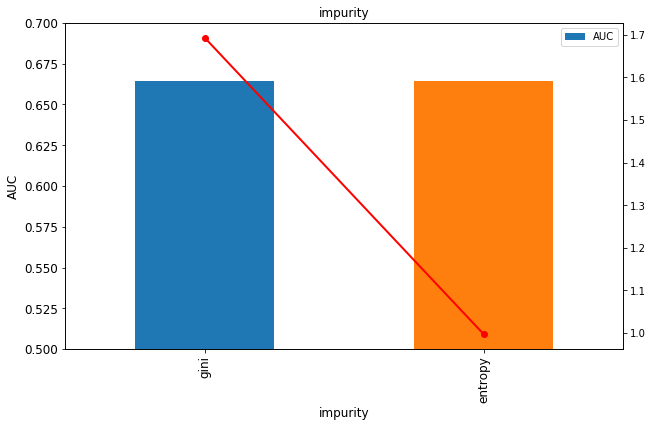

In [31]:
showchart(df,'impurity','AUC','duration',0.5,0.7 )


In [32]:
#定义evalParameter函数
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #训练评估参数
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #设置当前评估的参数
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #转换为Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #显示图形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )


训练评估：使用参数 impurity=gini maxDepth=3 maxBins=10
 ==>所需时间=0.727844953537 结果AUC = 0.616237450247
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=10
 ==>所需时间=0.809241056442 结果AUC = 0.671025663875
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=0.947578191757 结果AUC = 0.664119586526
训练评估：使用参数 impurity=gini maxDepth=15 maxBins=10
 ==>所需时间=1.16430020332 结果AUC = 0.658668983544
训练评估：使用参数 impurity=gini maxDepth=20 maxBins=10
 ==>所需时间=1.5894920826 结果AUC = 0.653292639458
训练评估：使用参数 impurity=gini maxDepth=25 maxBins=10
 ==>所需时间=1.40742087364 结果AUC = 0.651985682885


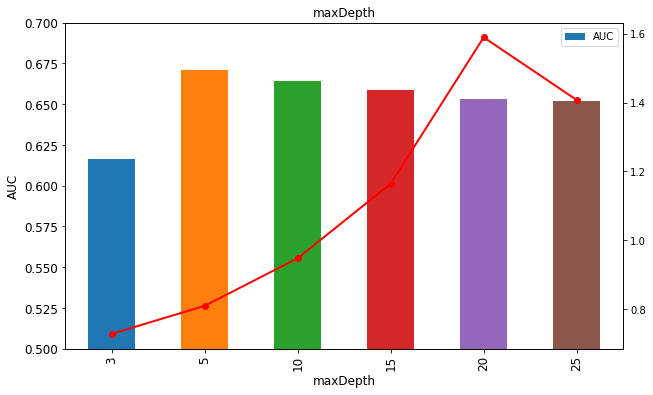

In [33]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10]) 


训练评估：使用参数 impurity=gini maxDepth=10 maxBins=3
 ==>所需时间=0.839622020721 结果AUC = 0.646609338799
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=5
 ==>所需时间=0.966753005981 结果AUC = 0.657362026971
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=0.874526977539 结果AUC = 0.664119586526
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=50
 ==>所需时间=0.857670068741 结果AUC = 0.658030357037
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=100
 ==>所需时间=1.37946391106 结果AUC = 0.655572387572
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=200
 ==>所需时间=1.18255901337 结果AUC = 0.647210835858


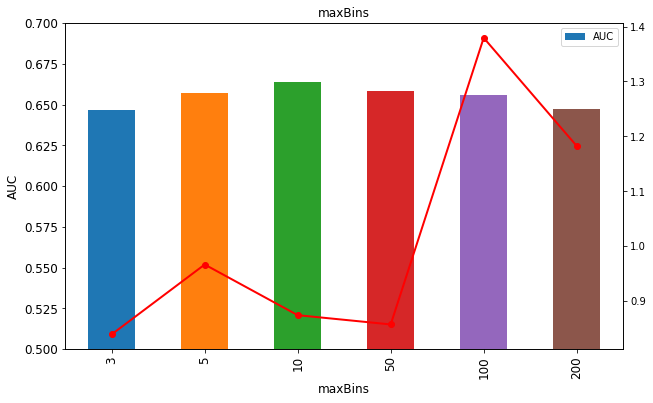

In [34]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])


In [35]:
#定义evalAllParameter函数，所有参数训练评估找出最好的参数组合
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for循环训练评估所有参数组合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的参数组合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #显示调校后最佳参数组合      
    print("调校后最佳参数：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    结果AUC = " + str(bestParameter[0]))
    #返回最佳模型
    return bestParameter[5]


In [36]:
print("-----所有参数训练评估找出最好的参数组合---------")  
bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])


-----所有参数训练评估找出最好的参数组合---------
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=3
 ==>所需时间=0.666985988617 结果AUC = 0.63422295491
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=5
 ==>所需时间=0.631012916565 结果AUC = 0.616237450247
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=10
 ==>所需时间=0.66606092453 结果AUC = 0.616237450247
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=50
 ==>所需时间=0.661516904831 结果AUC = 0.638671062793
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=100
 ==>所需时间=0.581458091736 结果AUC = 0.634378898592
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=200
 ==>所需时间=0.635277032852 结果AUC = 0.634378898592
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=3
 ==>所需时间=0.577271938324 结果AUC = 0.64187904711
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=5
 ==>所需时间=0.674824953079 结果AUC = 0.673335115547
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=10
 ==>所需时间=0.652437925339 结果AUC = 0.671025663875
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=50
 ==>所需时间=0.675385951996 结果AUC = 0.664453751559
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=